# Eigenfaces for Recognition

## Defining the Facespace

First, let's import all we need and set some useful variables and functions.

In [1]:
import numpy as np
import numpy.linalg as la
from numpy.random import default_rng
from ipywidgets import interact, interactive, fixed
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from mpl_toolkits.axes_grid1 import ImageGrid

rng = default_rng()

N = 92
M = 112
NM = N * M
training_dir = "./att_faces/Training"
testing_dir = "./att_faces/Testing"

def get_training_path_to_img(id: int, number: int):
    return training_dir + "/s" + str(id) + "/" + str(number) + ".pgm"

def get_testing_path_to_img(id: int):
    return testing_dir + "/s" + str(id) + "/" + str(id) + ".pgm"

# Returns a 1D array with the image data
def get_img(path: str):
    image = imread(path)
    return np.array(image, dtype = float).flatten()

def render_images(images: np.ndarray):
    fig = figure()
    
    nr_imgs = images.shape[1]
    
    rows = nr_imgs // 10 if nr_imgs % 10 == 0 else nr_imgs // 10 + 1
    
    grid = ImageGrid(fig, 111, 
                nrows_ncols=(rows, 12),
                axes_pad=0.1,  # pad between axes
                )
    for ax, im in zip(grid, images.T):
        ax.imshow(im.reshape(M, N), cmap = 'Greys_r')
        ax.axis('off')
        
def render_image(image):
    imshow(image, cmap = 'Greys_r')
    axis('off')

We will use the dataset from AT&T. Here's a sample of the faces we'll be using:

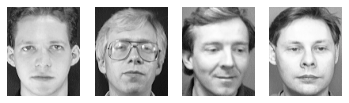

In [2]:
fig = figure()
for i in range(1, 5):
    path_to_img = get_training_path_to_img(i, i)
    fig.add_subplot(1, 4, i) 
    image = imread(path_to_img)
    render_image(image)

Every image has *M* rows and *N* columns. We shall collapse this matrix into a single vector with *N x M* rows.

Let's choose 10 random subjects from our data set and do the above.

In [3]:
# Returns a matrix with the given number of faces and the ids used: (face_matrix, training_set_ids)
def load_training_set(nr_of_subjects: int):
    training_set_ids = rng.choice(range(1, 41), size = nr_of_subjects, replace = False)
    face_matrix = np.zeros(shape = (NM, nr_of_subjects * 4), dtype = float)
    k = 0
    for id in training_set_ids:
        for j in range(1, 5):
            path_to_img = get_training_path_to_img(id, j)
            image_vector = get_img(path_to_img)
            face_matrix[:, k] = image_vector
            k += 1
    return face_matrix, training_set_ids
            
face_matrix, training_set_ids = load_training_set(20)

Let's take a look at the faces we chose:

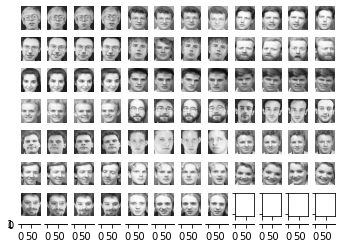

In [4]:
render_images(face_matrix)

The faces are now in a the `face_matrix`. Each column is a face. Now, let's compute the ***mean face***.

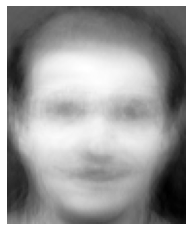

In [5]:
mean_face = np.zeros(shape = (NM,), dtype = float)

for face in face_matrix.T:
    mean_face += face
        
mean_face /= face_matrix.shape[1]

image = mean_face.reshape((M, N))
render_image(image)

Above you can see what the mean face looks like. Let's subtract it from the other faces, to **center the data**.

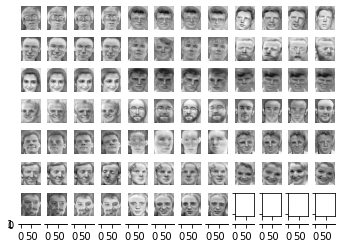

In [6]:
for i in range(0, face_matrix.shape[1]):
    face_matrix[:, i] -= mean_face

render_images(face_matrix)

And now, let's calculate our eigenfaces. They would, supposedly, be the eigenvectors of the covariance matrix of our `face_matrix`, ***A***, but we use a little trick: since the covariance matrix, ***C***, would be huge *((NM)^2 x (NM)^2)*, we will compute the eigenvectors of a smaller matrix, that we call `L_matrix` in the code. 

To understand why this works, see the math below.

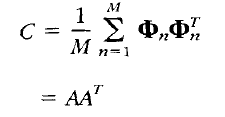

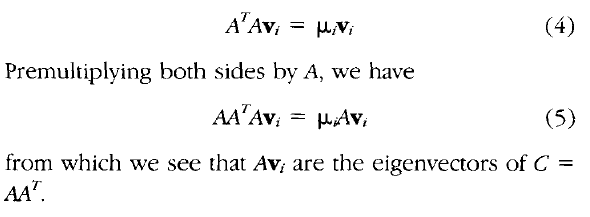

In [7]:
L_matrix = face_matrix.T @ face_matrix
eigenvalues, eigenvectors = la.eig(L_matrix)

eigenfaces = np.zeros(shape = face_matrix.shape, dtype = float)

for i in range(face_matrix.shape[1]):
    eigenfaces[:, i] = face_matrix @ eigenvectors[:, i]

Let's see what our (not so pretty) eigenfaces look like.

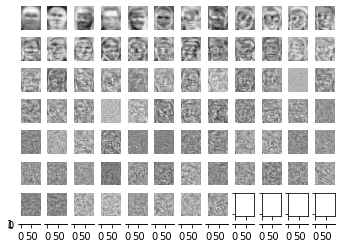

In [8]:
render_images(eigenfaces)

Now, let's get the eigenfaces that represent 95% of the variance in the dataset. These will be the basis of the ***face space***.

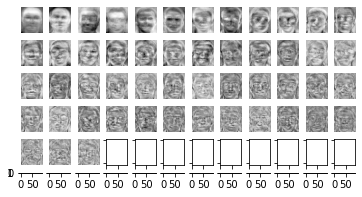

In [9]:
def get_var95_eigenfaces(evalues: np.ndarray, efaces: np.ndarray):
    def get_95var_indices():
        top_indices = eigenvalues.argsort()
        eig_total = eigenvalues.sum()
        c_sum = 0
        faces = []
    
        for i in reversed(top_indices):
            c_sum += eigenvalues[i]
            variance = c_sum / eig_total
            faces += [i]
        
            if variance > 0.95:
                break
        return faces
    
    indices = get_95var_indices()
    
    var95_eigenfaces = np.zeros((NM, len(indices)), dtype = float)
    
    for i, j in list(enumerate(indices)):
        var95_eigenfaces[:, i] = eigenfaces[:, j]
                
    return var95_eigenfaces

basis_eigenfaces = get_var95_eigenfaces(eigenvalues, eigenfaces)
render_images(basis_eigenfaces)

## Recognition

To recognize the face of a known individual, we need to create a ***face class*** — an average of the individual's known *eigenface representations* (the individual's face using the eigenfaces as base vectors).

After that, whenever we receive an input image and center it, we shall measure the distance of its *eigenface representation* to each ***face class***. We will also measure the distance between the original centered image and its projection in the *face space*. When we have these distances, we can do these three checks and act according to them:

- If the distance between the *eigenface representation* of the image to a face class, and the distance between the original centered image and the *face space* is below some threshold, then we can try to recognize it;
- If only the distance between the original centered image and the *face space* is below such threshold, then it's an unknown face;
- Otherwise, it's not a face.
    
Let's create the *face classes* first.

In [10]:
rand_ids_not_in_training_set = rng.choice([x for x in range(1, 41) if x not in training_set_ids],
                                            size = 8,
                                            replace = False)

rand_ids_from_training_set = rng.choice(training_set_ids, size = 8, replace = False)

test_set_ids = np.concatenate((rand_ids_not_in_training_set, rand_ids_from_training_set))

def get_weights_vector(image: np.ndarray):
    return basis_eigenfaces.T @ image

def compute_face_class(class_index: int):
    face_class = np.zeros((basis_eigenfaces.shape[1],), dtype = float)
    
    for i in range(1, 10):
        image_vector = get_img(get_training_path_to_img(class_index, i))
        image_vector -= mean_face
        face_class += get_weights_vector(image_vector)
    face_class /= 9
    
    return face_class

face_classes = {}
for i in training_set_ids:
    face_classes[i] = compute_face_class(i)

Now that we have our *face classes*, we can start receiving input images. But first, let's define functions to compute the distance to the *face classes* and to the *face space*.

In [11]:
def distance_to_face_class(kth_class: int, weights_vector: np.ndarray):
    return la.norm(weights_vector - face_classes[kth_class])

def distance_to_face_space(mean_centered_face: np.ndarray, projected_face: np.ndarray):
    return la.norm(mean_centered_face - projected_face)

Let's set a threshold to use for the acceptable distance between a face class or the face space and the input image.

In [12]:
threshold = 0

def set_threshold(theta: float):
    global threshold
    threshold = theta

interact(set_threshold, 
         theta = widgets.FloatLogSlider(
             value = 10e13,
             base = 10,
             min = 6,
             max = 24,
             step = .5,
             description = "threshold"
         ))

interactive(children=(FloatLogSlider(value=100000000000000.0, description='threshold', max=24.0, min=6.0, step…

<function __main__.set_threshold(theta: float)>

Now, let's use a set of sixteen images: eight from the training set and eight from outside the training set, and see the results!

Training ids:  [ 6 28  3 30 15 17  5 26]
Ids not in training set:  [11 29 14 32  9 40 20 34]

Image 11 is subject [38]!
Image 29 is subject [33]!
Image 14 is subject [28]!
Image 32 is subject [2]!
Image 9 is subject [17]!
Image 40 is subject [5]!
Image 20 is subject [30]!
Image 34 is subject [15]!
Image 6 is subject [6]!
Image 28 is subject [28]!
Image 3 is subject [3]!
Image 30 is subject [30]!
Image 15 is subject [15]!
Image 17 is subject [36]!
Image 5 is subject [18]!
Image 26 is subject [26]!


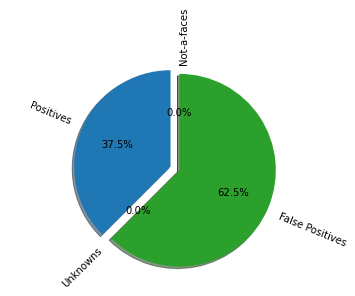

In [16]:
print("Training ids: ", rand_ids_from_training_set)
print("Ids not in training set: ", rand_ids_not_in_training_set, end="\n\n")

positives = 0
false_positives = 0
unknown_faces = 0
not_a_faces = 0

# Returns (classes, distance)
def get_closest_face_class(weights_vector: np.ndarray):
    ret_classes = []
    min_dist = float('inf')
    
    for k in face_classes:
        dist = distance_to_face_class(k, weights_vector)
        if (dist < min_dist):
            min_dist = dist
            ret_classes = [k]
        elif (dist == min_dist):
            ret_classes += [k]
            
    return ret_classes, min_dist

# Tries to recognize the image with the given weights and projection.
# Prints result and increments global counters for the pie graph in the end.
def try_to_recognize_image(weights_vector: np.ndarray, projected_image: np.ndarray):
    k, dist_to_a_face_class = get_closest_face_class(weights_vector)
    dist_to_face_space = distance_to_face_space(image_vector, projected_face)
    
    if dist_to_a_face_class < threshold and dist_to_face_space < threshold:
        print("Image {} is subject {}!".format(i, k))
        
        if i not in k:
            return "FP"
        else:
            return "P"
            
    elif dist_to_a_face_class >= threshold and dist_to_face_space < threshold:
        print("Image {} is an unknown subject!".format(i))
        return "UNK"
    else:
        print("Image {} is not a face!".format(i))
        return "NAF"
        
        
        
# Recognition loop
for i in test_set_ids:
    path_to_img = get_testing_path_to_img(i)
    image_vector = get_img(path_to_img)
    image_vector -= mean_face
    
    weights_vector = get_weights_vector(image_vector)
    projected_face = basis_eigenfaces @ weights_vector
        
    res = try_to_recognize_image(weights_vector, projected_face)
    
    if res == "P":
        positives += 1
    elif res == "FP":
        false_positives += 1
    elif res == "UNK":
        unknown_faces += 1
    elif res == "NAF":
        not_a_faces += 1
    
    
# Shows a pie graph of the results
        
labels = ["Positives", "Unknowns", "False Positives", "Not-a-faces"]
fig1, ax1 = plt.subplots()
ax1.pie([positives, unknown_faces, false_positives, not_a_faces],
        labels=labels,
        explode=(.1, 0, 0, 0),
        autopct='%1.1f%%',
        shadow=True,
        rotatelabels=True,
        startangle=90)

ax1.axis('equal')

plt.show()